# Homework 8

## ASTR 5900, Fall 2017, University of Oklahoma

### Gaussian Mixture Models

# Problem 1

### Part A

Load the Old Faithful data (http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat) and standardize each dimension such that they have zero mean and standard deviation of 1.

Use `sklearn.mixture.GaussianMixture` to estimate the density of the data using 2 Gaussian components. Take a look at the user guide ([link](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)) and the examples at the bottom of the page.

Plot the Old Faithful data using `matplotlib.pyplot` and overlay the points with the estimated density.  It is recommended you use a function such as `astroML.plotting.tools.draw_ellipse` ([link](https://github.com/astroML/astroML/blob/master/astroML/plotting/tools.py#L149)) to represent a Gaussian, but feel free to use any method you prefer that exists in `matplotlib`, `astropy`, `astroML`, or any other of the canonical python libraries.

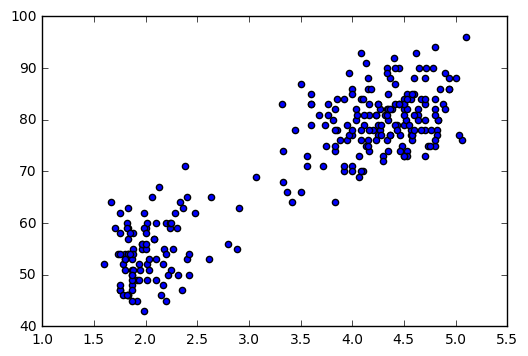

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import astroML
data = np.loadtxt('faithful.dat', skiprows=26)
x = data[:,1]
y = data[:,2]
plt.scatter(x,y)
plt.show()


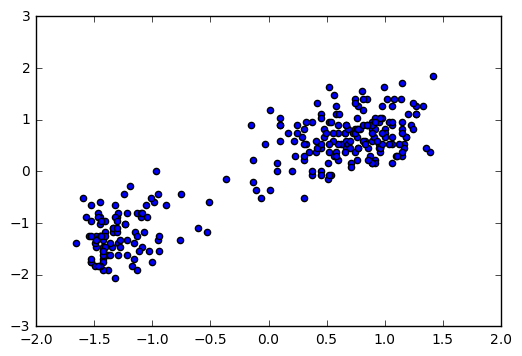

In [2]:
mu1 = x.mean()
sigma1 = x.std()


x1=np.asarray(x)

for i in range(len(x1)):
    x1[i]=(x1[i]-mu1)/sigma1
    


mu2=y.mean()
sigma2=y.std()

y1=np.asarray(y)

for i in range(len(y1)):
    y1[i]=(y1[i]-mu2)/sigma2
    
plt.scatter(x1,y1)
plt.show()



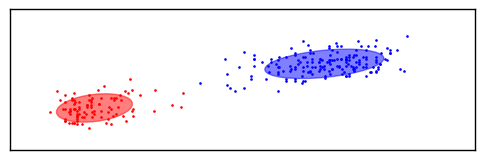

In [3]:
from sklearn import mixture
import matplotlib as mpl
from scipy import linalg

color_iter= ['red', 'blue']

def plot_results(X, Y_, means, covariances):
    splot = plt.subplot(2, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-2., 2.)
    plt.ylim(-3., 3.)
    plt.xticks(())
    plt.yticks(())


        
        
X = np.vstack((x1,y1)).T

gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)




plt.show()



In [4]:
print 'The derived positions of the Gaussians:', gmm.means_
print 'The covariances of the Gaussians: ',
print gmm.covariances_
print 'The weights on the Gaussians: ',gmm.weights_

The derived positions of the Gaussians: [[-1.27385192 -1.20982014]
 [ 0.70395466  0.66856949]]
The covariances of the Gaussians:  [[[ 0.05337217  0.02821933]
  [ 0.02821933  0.18303653]]

 [[ 0.13083984  0.06072079]
  [ 0.06072079  0.19563701]]]
The weights on the Gaussians:  [ 0.35592695  0.64407305]


### Part B

Using the *expectation-maximization* (EM) algorithm, build a Gaussian mixture model with 2 components from scratch for the Old Faithful data.  You are limited to default python and `numpy`.  

The EM algorithm was the subject of a 1977 paper by *Dempsey et al* (https://www.cse.iitb.ac.in/~pjyothi/cs753/EM.pdf).  Bishop describes the iterative procedure applied to GMM in Section 9.2.2.  The method is also in the lecture.  Plot each 'maximization' step in the same manner as what you did in Part A.

In [5]:
import matplotlib as mpl
import numpy.linalg

In [8]:
num_clusters=2
pi=np.array([0.5,0.5])
def gaussian(x,mu,covar):
    #gaussian is evaluated
    
    det=linalg.det(covar)
    sqrt_det=np.sqrt(det)
    inv_root_det=(1./sqrt_det)
    one_by_two = np.asarray((x[0]-mu[0],x[1]-mu[1]))
    two_by_one = np.reshape(one_by_two,(2,1))
    inv_covar = linalg.inv(covar)
    
    return (1./(2.*np.pi)) * inv_root_det * np.exp(-0.5*np.dot(np.dot(one_by_two,inv_covar),two_by_one))

def Expectation(mu, covar, pi): #outputs responsibility (gamma) 2d array, n x k. 
    gamma=np.zeros((len(x1),2))
    x=np.asarray((x1,y1)).T
    #build gamma array
    for i in range(len(x1)):
        for k in range(2):
            
            if k==0:
                gamma[i,k]=pi[k] *gaussian(x[i,:],mu[k,:],covar[[0,1],:])
            if k==1:
                gamma[i,k]=pi[k]*gaussian(x[i,:],mu[k,:],covar[[2,3],:])
                
        #normalize gamma
        gamma[i,0]=gamma[i,0]/(gamma[i,0]+gamma[i,1])
        gamma[i,1]=gamma[i,1]/(gamma[i,0]+gamma[i,1])
        
    return gamma

def maximization(gamma):  #returns new means, covars, weights
    N=np.zeros(2)
    N=np.reshape(N,(2,1))
    mu_new=np.zeros(4)
    mu_new=np.reshape(mu_new,(2,2))
    covar_new=np.zeros(8)
    covar_new=np.reshape(covar_new,(4,2))
    pi_new=np.zeros(2)
    pi_new=np.reshape(pi_new,(2,1))
    
    for k in range(2):
        N[k,0]=np.sum(gamma[:,k])
       
        for i in range(len(x1)):
            x=np.asarray((x1[i],y1[i])).T
            
            mu_new[k,0] += (1./(N[k,0]))*gamma[i,k]*x1[i]
            mu_new[k,1] += (1./(N[k,0]))*gamma[i,k]*y1[i]
            
    x=np.asarray((x1,y1)).T        
    for k in range(2):
        for i in range(len(x1)):
            
            if k==0:
                covar_new[[0,1],:] += (1./N[k,0])*gamma[i,k]*(x[i,:]-mu_new[k,:])* (x[i,:]-mu_new[k,:]).T
            if k==1:
                covar_new[[2,3],:] += (1./N[k,0]) *gamma[i,k]*(x[i,:]-mu_new[k,:])* (x[i,:]-mu_new[k,:]).T
                
    for k in range(2):
        pi_new[k,0]=N[k,0]/len(x1)
        
    return mu_new, covar_new, pi_new
            
            
            
            
            
            


def initialize():
    #return initial guesses for Gaussian model
    mu=np.random.uniform(-2,2,4)
    mu=np.reshape(mu,(2,2))

    covar=np.array([[1,0],[0,1],[1,0],[0,1]])

    pi=np.array([0.5,0.5])
    return mu, covar, pi
    
def plot(means,covars):
    
    #plot old faithful data
    plt.scatter(x1,y1)
    
    #plot ellipses
    
    color_iter= ['red', 'blue']
    splot = plt.subplot(2, 1, 1)
    for k in range(2):
        for i, (mean, covar, color) in enumerate(zip(means, covars, color_iter)):
            if k==0:
                v, w = linalg.eigh(covar[[0,1],:])
            if k==1:
                v, w = linalg.eigh(covar[[2,3],:])
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        

        # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(splot.bbox)
            ell.set_alpha(0.5)
            splot.add_artist(ell)

    plt.xlim(-2., 2.)
    plt.ylim(-3., 3.)
    plt.xticks(())
    plt.yticks(())

    
    plt.show()
    
    
def loglike(data,means,covars,weights):
    x=np.asarray((x1,y1)).T
    for i in range(len(x1)):
        for k in range(2):
            if k==0:
                k_sum_0 += pi[k,0] * gaussian(x[i,:],mu[k,:],covar[[0,1],:])
            if k==1:
                k_sum_1 += pi[k,0] * gaussian(x[i,:],mu[k,:],covar[[1,2],:])



def main(t): #argument is max number of iterations
    data=np.asarray((x1,y1)).T
    #initialize gaussian params
    mu, covar, pi = initialize()
    #plot(means, covars)
    
    for i in range(t):
        
        gamma = Expectation(mu, covar, pi)
        
        means, covars, weights = maximization(gamma)
        #plot(means,covars)
    return means, covars, weights
    

In [9]:
means, covars, weights =main(5)

In [10]:
print means

[[-0.3535331  -0.31432949]
 [ 0.94483656  0.95265508]]


In [11]:
print covars

[[ 0.96092028  1.01442258]
 [ 0.96092028  1.01442258]
 [ 0.08124345  0.16961939]
 [ 0.08124345  0.16961939]]


In [12]:
print weights

[[ 0.69725975]
 [ 0.03277852]]


# Problem 2

The data you will use for this homework problem comes from a Chandra
X-ray observatory observation of the Bullet Cluster.  The bullet
cluster is an important object in astronomy, as its morphology
compared with gravitational lensing results support the existence of
dark matter (versus, e.g., MOND).

### Part A

Load the data from `bullet.dat`.

Scatter plot the data.

Plot a 2d histogram of the data. Experiment with the binsize and plot representation until you obtain a pleasing image.  Comment on any structure you notice.

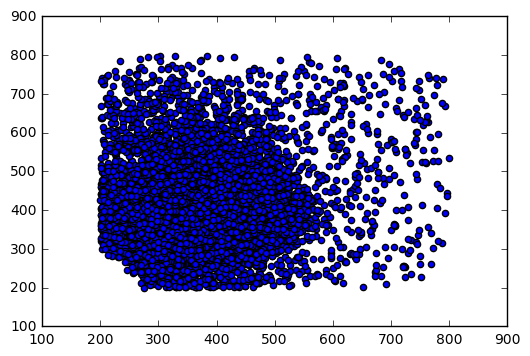

In [13]:
xray_data=np.loadtxt('bullet.dat')
x=xray_data[:,0]
y=xray_data[:,1]
plt.scatter(x,y)
plt.show()

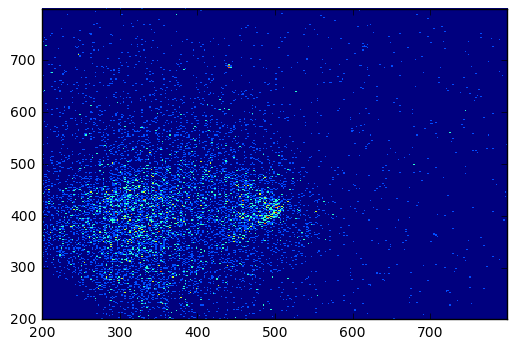

In [14]:
plt.hist2d(x,y,bins=300)
plt.show()

### Part B

Use `sklearn.mixture.GaussianMixture` to build a GMM on the bullet data with a range of components from 1 to 20.  Evaluate the AIC and BIC for each model.  Plot these criteria as a function of the number of components, with proper labels.  Consider how these functions are evaluated from the lecture and look up any helpful instance methods that belong to `GaussianMixture`.

Don't forget to the answer the discussion prompt below.

216088.701843
216124.166379


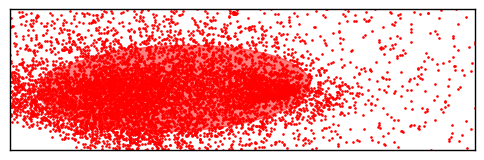

In [15]:

def plot_results(X, Y_, means, covariances):
    splot = plt.subplot(2, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(200., 700.)
    plt.ylim(200.,700.)
    plt.xticks(())
    plt.yticks(())

X=np.vstack((x,y)).T    
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full').fit(X)
print gmm.aic(X)
print gmm.bic(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)
plt.show()


214888.686842
214966.708822


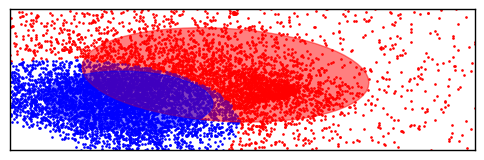

In [16]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)
print gmm.aic(X)
print gmm.bic(X)

plt.show()

213174.319055
213380.013366


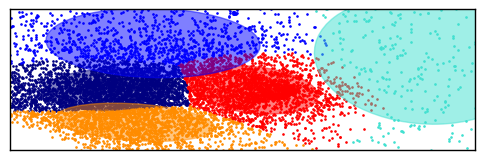

In [17]:
color_iter=['red','navy', 'turquoise', 'darkorange','blue','green']
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)

print gmm.aic(X)
print gmm.bic(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)
plt.show()

212877.66603
213296.14756


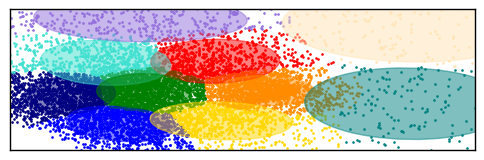

In [18]:
color_iter=['red','navy', 'turquoise', 'darkorange','blue','green','gold','moccasin','teal','mediumpurple','coral','crimson','deeppink','indigo','slategrey','fuchsia','darkcyan','royalblue','brown','tan','darksalmon','antiquewhite']
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full').fit(X)
print gmm.aic(X)
print gmm.bic(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)
plt.show()

212801.322379
213432.591126


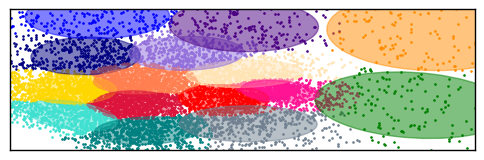

In [19]:
color_iter=['red','navy', 'turquoise', 'darkorange','blue','green','gold','moccasin','teal','mediumpurple','coral','crimson','deeppink','indigo','slategrey','fuchsia','darkcyan','royalblue','brown','tan','darksalmon','antiquewhite']
gmm = mixture.GaussianMixture(n_components=15, covariance_type='full').fit(X)
print gmm.aic(X)
print gmm.bic(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)
plt.show()

212692.181926
213536.237892


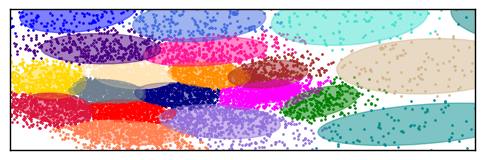

In [20]:
color_iter=['red','navy', 'turquoise', 'darkorange','blue','green','gold','moccasin','teal','mediumpurple','coral','crimson','deeppink','indigo','slategrey','fuchsia','darkcyan','royalblue','brown','tan','darksalmon','antiquewhite']
gmm = mixture.GaussianMixture(n_components=20, covariance_type='full').fit(X)
print gmm.aic(X)
print gmm.bic(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_)
plt.show()

[ 216088.70184281  214887.40980733  213764.98208727  213646.71361343
  213174.19947896  213163.84360138  213078.52986242  213014.82089002
  212907.39171676  212908.17807958  212853.30502811  212839.70729606
  212821.20200414  212827.48105418  212801.35437046  212771.719149
  212772.54626944  212772.83368283  212747.85501768  212732.64503472]


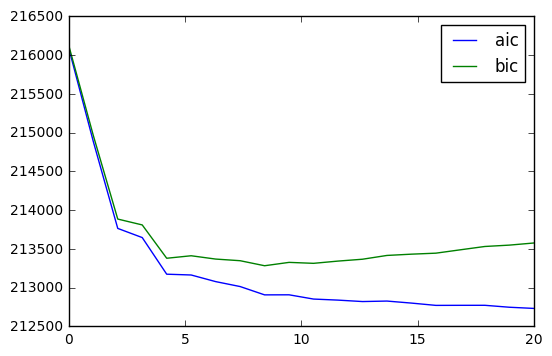

In [21]:
aic=[]
bic=[]
for i in range(1,21):
    gmm=mixture.GaussianMixture(n_components=i, covariance_type='full').fit(X)
    aic = np.append(aic,gmm.aic(X))
    bic= np.append(bic,gmm.bic(X))
    
x=np.linspace(0,20,20)
y1=aic
y2=bic

print aic

plt.plot(x,y1,label='aic')
plt.plot(x,y2,label='bic')
plt.legend()
plt.show()
    

## Discussion

Based on your results, which model best captures the structure of the data?  Why?  Do not just look at their information criteria; consider how well each model passes the 'eye test'.

Visually it looks like 10 components model the data the best, this is confirmed by the bic

# Problem Z

Comment on how long this assignment took to complete.

It took me about 8 hours to get as far as I did with this assignment.